In [1]:
# code for loading the format for the notebook
import os

# path : store the current path to convert back to it later
path = os.getcwd()
os.chdir( os.path.join('..', 'notebook_format') )
from formats import load_style
load_style()

In [2]:
os.chdir(path)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
%matplotlib inline
%load_ext watermark
%load_ext autoreload 
%autoreload 2

import tensorflow as tf

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,matplotlib,tensorflow

Ethen 2017-03-20 11:48:50 

CPython 3.5.2
IPython 5.1.0

numpy 1.12.0
pandas 0.19.2
matplotlib 1.5.3
tensorflow 1.0.1


# Tensorflow

TensorFlow provides multiple APIs. The lowest level API--TensorFlow Core-- provides you with complete programming control. We recommend TensorFlow Core for machine learning researchers and others who require fine levels of control over their models

## Hello World

We think of TensorFlow Core programs as consisting of two discrete sections:

- Building the computational graph.
- Running the computational graph.

In [3]:
# note that this is simply telling tensorflow to 
# create a constant operation, nothing gets
# executed until we start a session and run it
hello = tf.constant('Hello, TensorFlow!')
hello

<tf.Tensor 'Const:0' shape=() dtype=string>

In [4]:
# start the session and run the graph
with tf.Session() as sess:
    print( sess.run(hello) )

b'Hello, TensorFlow!'


We can think of tensorflow as a system to define our computation, and using the operation that we've defined it will construct a computation graph (where each operation becomes a node in the graph). The computation graph that we've defined will not be `run` unless we give it some context and explicitly tell it to do so. In this case, we create the `Session` that encapsulates the environment in which the objects are evaluated (execute the operations that are defined in the graph).

Consider another example that simply add and multiply two constant numbers.

In [5]:
a = tf.constant(2.0, tf.float32)
b = tf.constant(3.0) # also tf.float32 implicitly
c = a + b

with tf.Session() as sess:
    print( 'mutiply: ', sess.run(a * b) )
    print( 'add: ', sess.run(c) ) # note that we can define the add operation outside 
    print( 'add: ', sess.run(a + b) ) # or inside the .run()

mutiply:  6.0
add:  5.0
add:  5.0


The example above is not especially interesting because it always produces a constant result. A graph can be parameterized to accept external inputs, known as `placeholders`. Think of it as the input data we would give to machine learning algorithm at some point.

We can do the same operation as above by first defining a `placeholder` (note that we must specify the data type). Then `feed` in values using `feed_dict` when we `run` it.

In [6]:
a = tf.placeholder(tf.float32)
b = tf.placeholder(tf.float32)

# define some operations
add = a + b
mul = a * b

with tf.Session() as sess:
    print( 'mutiply: ', sess.run(mul, feed_dict = {a: 2, b: 3}) )
    print( 'add: ', sess.run(add, feed_dict = {a: 2, b: 3}) )

mutiply:  6.0
add:  5.0


Some matrix operations are the same compared to numpy. e.g. 	

In [7]:
c = np.array([[3.,4], [5.,6], [6.,7]])
print(c)
print( np.mean(c, axis = 1) )
print( np.argmax(c, axis = 1) )

with tf.Session() as sess:
    result = sess.run( tf.reduce_mean(c, axis = 1) )
    print(result)
    print( sess.run( tf.argmax(c, axis = 1) ) )

[[ 3.  4.]
 [ 5.  6.]
 [ 6.  7.]]
[ 3.5  5.5  6.5]
[1 1 1]
[ 3.5  5.5  6.5]
[1 1 1]


The functionality of `numpy.mean` and `tensorflow.reduce_mean` are the same. When axis argument parameter is 1, it computes mean across (3,4) and (5,6) and (6,7), so 1 defines across which axis the mean is computed (axis = 1, means the operation is along the column, so it will compute the mean for each row). When it is 0, the mean is computed across(3,5,6) and (4,6,7), and so on. The same can be applied to argmax which returns the index that contains the maximum value along an axis.

## Linear Regression

We'll start off by writing a simple linear regression model. To do so, we first need to understand the difference between `tf.Variable` and `tf.placeholder`. 

> [Stackoverflow](http://stackoverflow.com/questions/36693740/whats-the-difference-between-tf-placeholder-and-tf-variable). The difference is that with `tf.Variable` you have to provide an initial value when you declare it. With `tf.placeholder` you don't have to provide an initial value and you can specify it at run time with the `feed_dict` argument inside `Session.run`.
> In short, we will use `tf.Variable` for trainable variables such as weights (W) and biases (B) for our model. On the other hand, `tf.placeholder` is used to feed actual training examples.

Also note that, constants are automatically initialized when we call `tf.constant`, and their value can never change. By contrast, variables are not initialized when we call `tf.Variable`. To initialize all the variables in a TensorFlow program, we must explicitly call a special operation called `tf.global_variables_initializer()`. Things will become clearer with the example below.

In [8]:
# Parameters
learning_rate = 0.01 # learning rate for the optimizer (gradient descent)
n_epochs = 1000 # number of iterations to train the model
display_epoch = 100 # display the cost for every display_step iteration

In [9]:
# make up some trainig data
X_train = np.asarray([3.3,4.4,5.5,6.71,6.93,4.168,9.779,6.182,7.59,
                      2.167,7.042,10.791,5.313,7.997,5.654,9.27,3.1])
y_train = np.asarray([1.7,2.76,2.09,3.19,1.694,1.573,3.366,2.596,2.53,
                      1.221,2.827,3.465,1.65,2.904,2.42,2.94,1.3])

# placeholder for the input data
X = tf.placeholder(tf.float32)
Y = tf.placeholder(tf.float32)

# give the model's parameter a randomized initial value
W = tf.Variable(np.random.randn(), tf.float32, name = "weight")
b = tf.Variable(np.random.randn(), tf.float32, name = "bias")

# Construct the formula for the linear model
# we can also do
# pred = tf.add(tf.multiply(X, W), b)
pred = W * X + b

# we then define the loss function that the model is going to optimize on,
# here we use the standard mean squared error, which is sums the squares of the
# prediction and the true y divided by the number of observations, note
# that we're computing the difference between the prediction and the y label
# from the placeholder
cost = tf.reduce_mean(tf.pow(pred - Y, 2))

# after defining the model structure and the function to optimize on,
# tensorflow provides several optimizers that can do optimization task
# for us, the simplest one being gradient descent
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
train = optimizer.minimize(cost)

# initializing the variables
init = tf.global_variables_initializer()

Epoch: 100, cost: 0.30015939474105835
Epoch: 200, cost: 0.24383427202701569
Epoch: 300, cost: 0.2091939002275467
Epoch: 400, cost: 0.18788985908031464
Epoch: 500, cost: 0.17478768527507782
Epoch: 600, cost: 0.16672979295253754
Epoch: 700, cost: 0.16177406907081604
Epoch: 800, cost: 0.15872631967067719
Epoch: 900, cost: 0.1568519026041031
Epoch: 1000, cost: 0.15569919347763062
Optimization Finished!
Training cost: 0.15569919347763062, W: 0.26883816719055176, b: 0.676838219165802


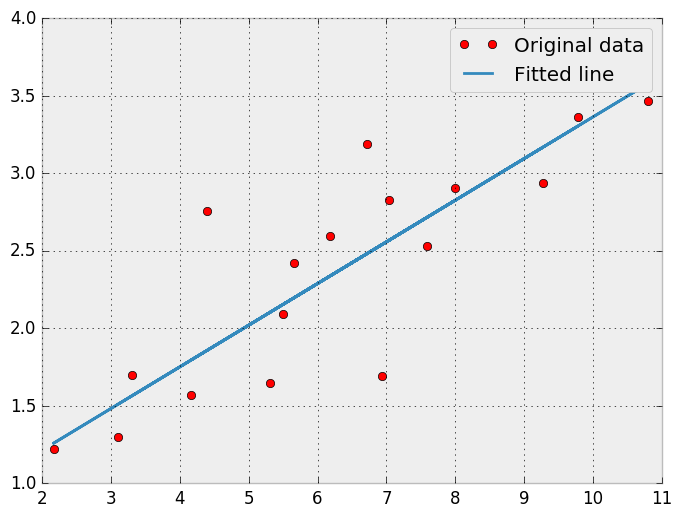

In [10]:
# change default figure and font size
plt.rcParams['figure.figsize'] = 8, 6 
plt.rcParams['font.size'] = 12

# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    feed_dict = {X: X_train, Y: y_train}

    # Fit on all the training data
    for epoch in range(n_epochs):
        #for x, y in zip(X_train, y_train):
        sess.run(train, feed_dict = feed_dict)

        #Display logs per epoch step
        if (epoch + 1) % display_epoch == 0:
            # run the cost to obtain the value for the cost function at each step
            c = sess.run(cost, feed_dict = feed_dict)
            print("Epoch: {}, cost: {}".format(epoch + 1, c))

    print("Optimization Finished!")
    c = sess.run(cost, feed_dict = feed_dict)
    weight = sess.run(W)
    bias = sess.run(b)
    print("Training cost: {}, W: {}, b: {}".format(c, weight, bias))

    # graphic display
    plt.plot(X_train, y_train, 'ro', label='Original data')
    plt.plot(X_train, weight * X_train + bias, label = 'Fitted line')
    plt.legend()
    plt.show()

## MNIST Using Softmax

MNIST is a simple computer vision dataset. It consists of images of handwritten digits like these:

<img src='images/mnist.png'>

Each image is 28 pixels by 28 pixels, which is essentially a $28 \times 28$ array of numbers. To use it in a context of a machine learning problem, we can flatten this array into a vector of $28 \times 28 = 784$, this will be the number of features for each image. It doesn't matter how we flatten the array, as long as we're consistent between images. Note that, flattening the data throws away information about the 2D structure of the image. Isn't that bad? Well, the best computer vision methods do exploit this structure. But the simple method we will be using here, a softmax regression (defined below), won't.

The dataset also includes labels for each image, telling us the each image's label. For example, the labels for the above images are 5, 0, 4, and 1. Here we're going to train a softmax model to look at images and predict what digits they are. The possible label values in the MNIST dataset are numbers between 0 and 9, hence this will be a 10-class classification problem.

In [11]:
# convenient one-liner to load the dataset
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data/', one_hot = True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


The downloaded data is split into three parts, 55,000 data points of training data (mnist.train), 10,000 points of test data (mnist.test), and 5,000 points of validation data (mnist.validation).

Every part of the dataset contains the data and label and we can access them via `.images` and `.labels`. e.g. the training images are mnist.train.images and the train labels are mnist.train.labels (one-hot encoded).

In [12]:
# pixels 
print(mnist.train.images.shape)
mnist.train.images

(55000, 784)


array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [13]:
# one-hot encoded labels
print(mnist.train.labels.shape)
mnist.train.labels

(55000, 10)


array([[ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

In the following code chunk, we define the overall computational graph/structure for the softmax classifier using the cross entropy cost function as the objective. Recall that the formula for this function can be denoted as:

$$L = -\sum_i y'_i \log(y_i)$$

Where y is our predicted probability distribution, and y′ is the true distribution.

In [14]:
# define some global variables
learning_rate = 0.5 
batch_size = 100
n_iterations = 1000
n_features = mnist.train.images.shape[1]
n_class = mnist.train.labels.shape[1]

# define the input and output 
# here None means that a dimension can be of any length,
# which is what we want, since the number of observations
# we have can vary;
# note that the shape argument to placeholder is optional, 
# but it allows TensorFlow to automatically catch bugs stemming 
# from inconsistent tensor shapes
X = tf.placeholder( tf.float32, [None, n_features] )
y = tf.placeholder( tf.float32, [None, n_class] )

# initialize both W and b as tensors full of zeros. 
# these are parameters that the model is later going to learn,
# Notice that W has a shape of [784, 10] because we want to multiply 
# the 784-dimensional image vectors by it to produce 10-dimensional 
# vectors of evidence for the difference classes. b has a shape of [10] 
# so we can add it to the output.
W = tf.Variable( tf.zeros([n_features, n_class]) )
b = tf.Variable( tf.zeros([n_class]) )

```python
# to define the softmax classifier and cross entropy cost
# we can do the following

# matrix multiplication using the .matmul command
# and add the softmax output
output = tf.nn.softmax( tf.matmul(X, W) + b )

# cost function: cross entropy, the reduce mean is simply the average of the
# cost function across all observations
cross_entropy = tf.reduce_mean( -tf.reduce_sum(y * tf.log(output), axis = 1) )

```

In [15]:
# but for numerical stability reason, the tensorflow documentation
# suggests using the foloowing function
output = tf.matmul(X, W) + b
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = y, logits = output))

Now that we defined the structure of our model, we'll:

1. Define a optimization algorithm the train it. In this case, we ask TensorFlow to minimize our defined cross_entropy cost using the gradient descent algorithm with a learning rate of 0.5. There are also other off the shelf [optimizers](https://www.tensorflow.org/api_guides/python/train#optimizers) that we can use that are faster for more complex models.
2. We'll also add an operation to initialize the variables we created
3. Define helper "function" to evaluate the prediction accuracy

In [16]:
train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
init = tf.global_variables_initializer()

# here we're return the predicted class of each observation using argmax
# and see if the ouput (prediction) is equal to the target variable (y)
# since equal is a boolean type tensor, we cast it to a float type to compute
# the actual accuracy
correct_prediction = tf.equal( tf.argmax(y, axis = 1), tf.argmax(output, axis = 1) )
accuracy = tf.reduce_mean( tf.cast(correct_prediction, tf.float32) )

Now it's time to run it. During each step of the loop, we get a "batch" of one hundred random data points (defined by `batch_size`) from our training set. We run train_step feeding in the batches data to replace the placeholders.

Using small batches of random data is called stochastic training -- in this case, stochastic gradient descent. Ideally, we'd like to use all our data for every step of training because that would give us a better sense of what we should be doing, but that's expensive. So, instead, we use a different subset every time. Doing this is cheap and has much of the same benefit.

In [17]:
with tf.Session() as sess:
    
    # initialize the variable, train the "batch" gradient descent
    # for a specified number of iterations and evaluate on accuracy score
    # remember the key to the feed_dict dictionary must match the variable we use
    # as the placeholder for the data in the beginning
    sess.run(init)
    for i in range(n_iterations):
        X_batch, y_batch = mnist.train.next_batch(batch_size)
        _, acc = sess.run([train_step, accuracy], feed_dict = {X: X_batch, y: y_batch})
        
        # simply prints the training data's accuracy for every 100 iteration
        if i % 100 == 0:
            print(acc)
    
    # after training evaluate the accuracy on the testing data
    acc = sess.run(accuracy, feed_dict = {X: mnist.test.images, y: mnist.test.labels})
    print('test:', acc)

0.12
0.95
0.93
0.95
0.88
0.92
0.86
0.89
0.98
0.95
test: 0.9201


Notice that we did not have to worry about computing the gradient to update the model, the nice thing about Tensorflow is that, once we've defined the structure of our model it has the capability to automatically differentiate mathematical expressions. This means we no longer need to compute the gradients ourselves! In this example, our softmax classifier obtained pretty nice result around 92%. But we can certainly do better with more advanced techniques such as convolutional deep learning.

## Reference

- [Gituhb: Tensorflow Examples - Linear Regression](https://github.com/aymericdamien/TensorFlow-Examples/blob/master/notebooks/2_BasicModels/linear_regression.ipynb)
- [Tensorflow Documentation: Getting Started With TensorFlow](https://www.tensorflow.org/get_started/get_started)
- [TensorFlow Documentation: MNIST For ML Beginners](https://www.tensorflow.org/get_started/mnist/beginners)